In [1]:
import os, glob, platform
import numpy as np
import numpy.matlib
import pickle
import pandas as pd
import pathlib
import matplotlib
import matplotlib.pyplot as plt
import mne
mne.__version__
from mne.viz import plot_alignment, snapshot_brain_montage
import shutil
from mne.datasets import eegbci
from sklearn.model_selection import train_test_split

# from mne_bids import write_raw_bids, BIDSPath, print_dir_tree, make_dataset_description
# from mne_bids.stats import count_events
import sys


In [2]:
''' VARIABLES '''

dataset = 'eeg'

amount_of_subjects = 27 # Change the range so the process is faster

numC = 8

angles = [i * 180./numC for i in range(numC)]

x_labels = np.array(angles)

resample = True # speeds up the procees but showing worse results overall
resample_frequency = 20 # in Hz, original freq is 500Hz

In [3]:
from toolbox.methods import read_data
all_epochs, all_rawdata = read_data (task = 'main', resample=resample, amount_of_subjects=amount_of_subjects, resample_frequency=resample_frequency)

In [5]:
from sklearn.svm import SVC
# from pyrcn.echo_state_network import ESNClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from catboost import CatBoostClassifier
# from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

def train_timepoints(X, y, verbose=False, display_roc=False, acc_only = False):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    minority = np.unique(y_train,return_counts=True)[1][0]
    mayority = np.unique(y_train,return_counts=True)[1][1]
    # print(mayority/minority)
    class_weight = {
        0: 1.0,  
        1: mayority/minority
    }
    sample_weights = np.array([class_weight[label] for label in y_train])
    
    clf = CatBoostClassifier(task_type = 'GPU')
    clf = RandomForestClassifier(random_state=0, n_jobs=-1)
    # clf = LinearSVC(random_state=0, loss="hinge") # Faster than Random Forest
    clf.fit(X_train, y_train,
            sample_weight=sample_weights
            )

    y_pred = clf.predict(X_test)    
    if verbose:
        print(classification_report(y_test, y_pred))
        print(np.unique(y_test, return_counts=True))
        print(np.unique(y_pred, return_counts=True))
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred)
    # features = clf.feature_importances_
    if display_roc:
        # I think this is not working
        from sklearn.metrics import roc_curve
        from sklearn.metrics import RocCurveDisplay
        fpr, tpr, _ = roc_curve(y_test, y_pred, pos_label=clf.classes_[1])
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
        return roc_display
    # if np.unique(y_pred, return_counts=True)[1].shape[0] == 1:
    #     unique_pred_0 = 0
    #     unique_pred_1 = np.unique(y_pred, return_counts=True)[1][0]  
    # else:
    #     unique_pred_0 = np.unique(y_pred, return_counts=True)[1][0]
    #     unique_pred_1 = np.unique(y_pred, return_counts=True)[1][1]
    if acc_only:
        return accuracy
    return accuracy, f1, roc #, features

real data mean acc = 0.64

shuffled data mean acc = 0.58


In [32]:
y = all_rawdata[0]['metadata']['deci']
y = np.array(y)
random.shuffle(y)
print(len(y))

250


# Mean acc for all subjects

In [33]:
# MAKE A SLIDING TIMEPOINT WINDOW TOO
import random
subject_acc = [None]*amount_of_subjects
timepoint_accuracy = [None]*amount_of_subjects
for subj in range(amount_of_subjects-1):
    
    print('Working on subj: ', subj)
    X = all_rawdata[subj]['epoch_dat']
    y = all_rawdata[subj]['metadata']['deci']
    y = np.array(y)
    random.shuffle(y)
    numT = X.shape[2]
    timepoint_accuracy[subj] = [None]*numT
    y = np.array(y)
    for timepoint in range(numT):
        # print(timepoint)
        X_training = X[:,:,timepoint]
        timepoint_accuracy[subj][timepoint] = train_timepoints(X_training, y, verbose=False, acc_only=True)

# subject_acc[subj] = np.mean(timepoint_accuracy)
    

Working on subj:  0
Working on subj:  1
Working on subj:  2
Working on subj:  3
Working on subj:  4
Working on subj:  5
Working on subj:  6
Working on subj:  7
Working on subj:  8
Working on subj:  9
Working on subj:  10
Working on subj:  11
Working on subj:  12
Working on subj:  13
Working on subj:  14
Working on subj:  15
Working on subj:  16
Working on subj:  17
Working on subj:  18
Working on subj:  19
Working on subj:  20
Working on subj:  21
Working on subj:  22
Working on subj:  23
Working on subj:  24
Working on subj:  25


In [38]:
import csv
# filename = "RandomForest_deci_shuffled.csv"

with open(filename, "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(timepoint_accuracy)

In [27]:
df = pd.read_csv('RandomForest_deci.csv')

In [37]:
import csv

filename = "RandomForest_deci_shuffled.csv"

with open(filename, "r") as file:
    reader = csv.reader(file)
    my_list = next(reader)

print(my_list[1])

FileNotFoundError: [Errno 2] No such file or directory: 'RandomForest_deci_shuffled.csv'

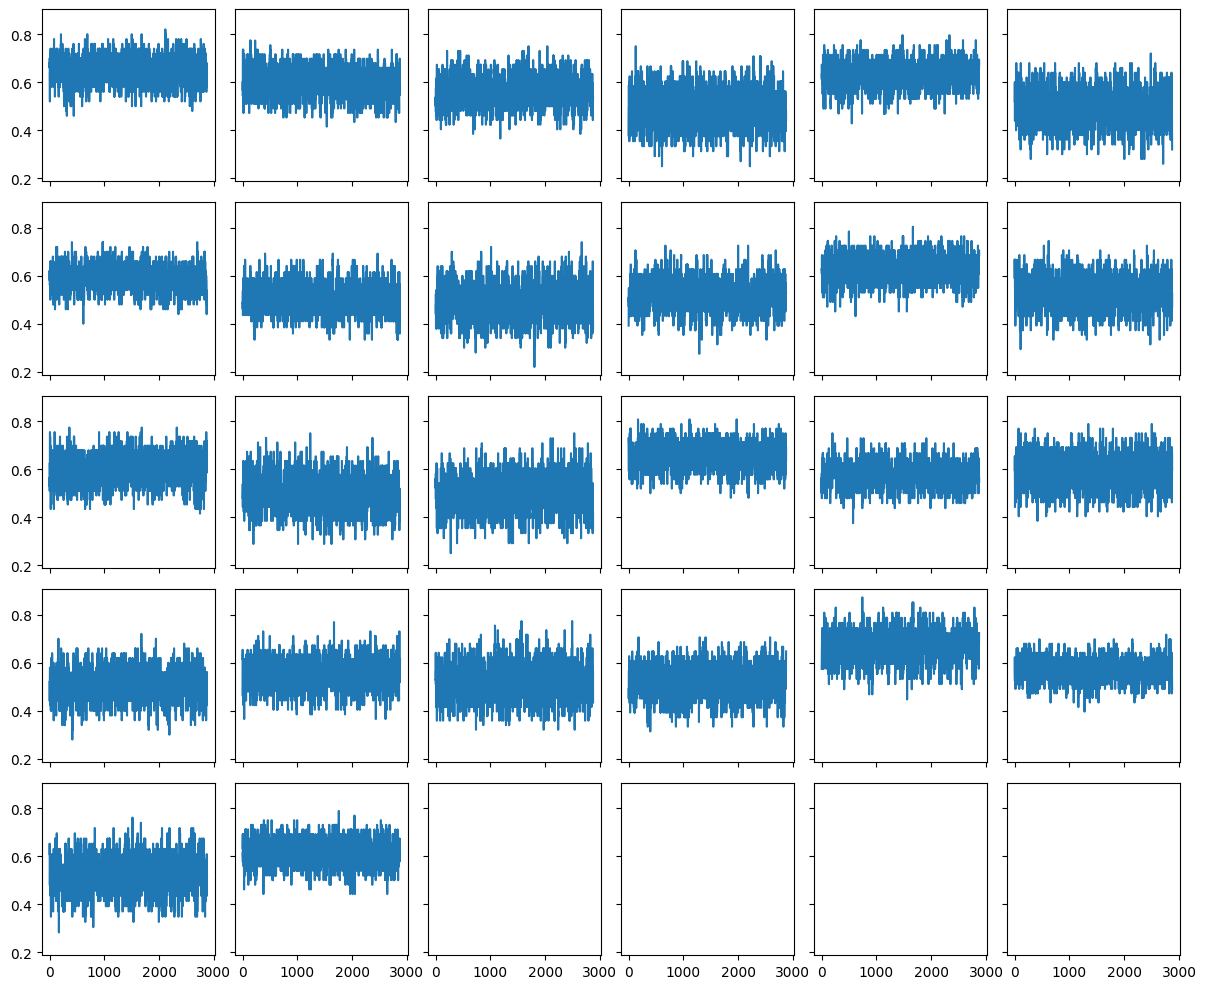

In [34]:
fig, axs = plt.subplots(5, 6, sharex=True, sharey=True, figsize=(12, 10))

for i in range(26):
    row = i // 6
    col = i % 6
    axs[row, col].plot(timepoint_accuracy[i])

plt.tight_layout()
plt.show()

In [49]:
mean_accuracy = np.mean(np.array(timepoint_accuracy), axis=0)
plt.plot(mean_accuracy)

TypeError: can only concatenate list (not "NoneType") to list

In [39]:
mean_timepoint = [0]*numT
for t in range(numT):
    sum = 0
    for i in range(amount_of_subjects-1):
        sum = sum + timepoint_accuracy[i][t]
    mean_timepoint[t] = sum/26.

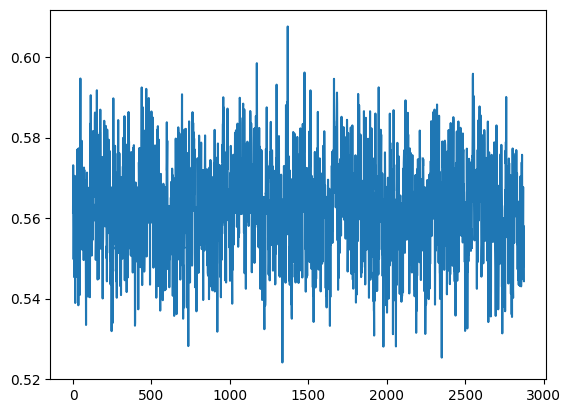

In [40]:
plt.plot(mean_timepoint)

# RESULTS

In [34]:
np.mean(timepoint_accuracy[0])

0.6425452016689848

In [39]:
subj_mean_acc = [None]*amount_of_subjects
for i in range (amount_of_subjects-1):
    subj_mean_acc[i] =np.mean( timepoint_accuracy[i])

In [45]:
print('Mean acc for each subj using Random Forest', subj_mean_acc[0:26])
print('Total mean', np.mean(subj_mean_acc[0:26]))

Mean acc for each subj using Random Forest [0.6425452016689848, 0.5864801742462014, 0.5646062907884881, 0.5187760778859527, 0.617056001816582, 0.48865785813630047, 0.6327955493741307, 0.5565243750222888, 0.5034353268428372, 0.5488218931522539, 0.6549196869290136, 0.533925113856391, 0.570216758075944, 0.4941224457045041, 0.5179357904496986, 0.5864715951642238, 0.5396021673620769, 0.5903632181448593, 0.5243602225312934, 0.5961605327912699, 0.5162174928490828, 0.5916714390902397, 0.6179460243245642, 0.6461476894008975, 0.5571219084477234, 0.642652722798759]
Total mean 0.5707512906482524


Mean acc for each subj using Random Forest
 
[0.6425452016689848, 0.5864801742462014, 0.5646062907884881, 0.5187760778859527, 0.617056001816582, 0.48865785813630047, 0.6327955493741307, 0.5565243750222888, 0.5034353268428372, 0.5488218931522539, 0.6549196869290136, 0.533925113856391, 0.570216758075944, 0.4941224457045041, 0.5179357904496986, 0.5864715951642238, 0.5396021673620769, 0.5903632181448593, 0.5243602225312934, 0.5961605327912699, 0.5162174928490828, 0.5916714390902397, 0.6179460243245642, 0.6461476894008975, 0.5571219084477234, 0.642652722798759]


Total mean 0.5707512906482524

In [ ]:
X_training = X[:,:,1500]
print(train_3(X_training, y, verbose=True))

In [ ]:
from sklearn.svm import SVC
# from pyrcn.echo_state_network import ESNClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
# from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# scaler = StandardScaler()

clf = CatBoostClassifier(task_type = 'GPU')
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on test set:", accuracy)



catboost and RF both on more data with stacked are perfoming the same

next im gonna add labels for the subjects


In [ ]:
display(all_rawdata[0]['metadata'].columns)

In [ ]:
print(multivariate)

# multivariate test?

https://pypi.org/project/pyts/

In [ ]:
from pyts.classification import BOSSVS
from pyts.multivariate.classification import MultivariateClassifier

from pyts.datasets import load_basic_motions

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# X_train, X_test, y_train, y_test = load_basic_motions(return_X_y=True)

print(X_train.shape, y_train.shape)

# scaler = StandardScaler()

clf = CatBoostClassifier(task_type = 'GPU')
clf = RandomForestClassifier()
clf = MultivariateClassifier(BOSSVS())
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on test set:", accuracy)

